In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs  
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import numpy as np
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
from time import time
from alibi.explainers import CounterFactual, CounterFactualProto
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False
import pickle

TF version:  2.2.0
Eager execution enabled:  False


In [2]:
model_nt3 = tf.keras.models.load_model('/vol/ml/shahashka/xai-geom/nt3/nt3.autosave.model')
with open('/vol/ml/shahashka/xai-geom/nt3/nt3.autosave.data.pkl', 'rb') as pickle_file:
    X_train,Y_train,X_test,Y_test = pickle.load(pickle_file)

In [3]:
shape_cf = (1,) + X_train.shape[1:] 
print(shape_cf)
target_proba = 0.9
tol = 0.1 # want counterfactuals with p(class)>0.90
target_class = 'other' # any class other than will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 20
learning_rate_init = 0.1
feature_range = (0,1)

cf = CounterFactual(model_nt3, shape=shape_cf, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                    feature_range=feature_range)

(1, 60483, 1)


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d/conv1d}}]]
	 [[activation_4/Softmax/_83]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d/conv1d}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
shape = X_train[0].shape[0]
results=[]
for i in np.arange(0,5):
    x_sample=X_train[i:i+1]
    print(x_sample.shape)
    start = time()
    try:
        explanation = cf.explain(x_sample)
        print('Counterfactual prediction: {}, {}'.format(explanation.cf['class'], explanation.cf['proba']))
        print("Actual prediction: {}".format(model_nt3.predict(x_sample)))
        results.append([explanation.cf['X'],explanation.cf['class'], explanation.cf['proba']])
    # if counterfactual not found make a dummy array   
    except IndexError:
        dummy = np.empty(x_sample.shape)
        dummy[:] = np.nan
        results.append(dummy)

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
pickle.dump(results, open("small_cf_test.pkl", "wb"))

In [ ]:
for i in range(len(results)):
    plt.figure(figsize=(20, 4))
    sample = X_train[i].flatten()
    y = results[i][0].flatten()
    x = np.arange(y.shape[0])
    plt.plot(x,y,alpha=0.5, label='counterfactual')
    plt.plot(x,sample,alpha=0.5, label='input')
    plt.plot(x,sample-y, label='diff')
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    prediction = model_nt3.predict(X_test[i:i+1])
    plt.text(0.05, 0.95, "original input: {} {} \n counterfactual: {} {}".format(np.argmax(prediction), 
                                                         prediction,results[i][1] ,results[i][2]), 
             fontsize=16,
        verticalalignment='top', bbox=props)
    plt.legend()
    plt.show()

In [7]:
from scipy.stats import pearsonr
Y_flag = np.argmax(Y_test,axis=1)

for r in range(len(results)):
    pearson_0 = []
    pearson_1 = []
    for i in range(len(Y_flag)):
        if Y_flag[i]==0:
            pearson_0.append(pearsonr(results[r][0].flatten(), X_test[i].flatten())[0])
        else:
            pearson_1.append(pearsonr(results[r][0].flatten(), X_test[i].flatten())[0])

    print(np.average(pearson_0))
    print(np.average(pearson_1))
    print("\n")

0.4542566392434886
0.4086305624547959


0.5043837824693964
0.46664387832620924


0.6335310691943951
0.6069955054804324


0.6563886318117149
0.5876853023454891


0.16572694427639978
0.1858917752190248




In [8]:
Y_predict = model_nt3.predict(X_test)
noise = np.random.uniform(-0.3, 0.3, X_test.shape)
Y_predict_noise = model_nt3.predict(X_test+noise)
print(Y_predict_noise[0])

[0.36569104 0.634309  ]


Text(0.5, 1.0, 'Class 0 predictions with uniform random noise [-0.2,0.2]')

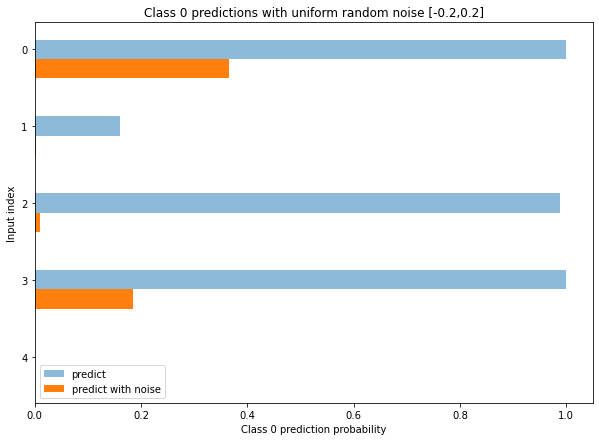

In [9]:
Y_flag_predict = np.argmax(Y_predict,axis=1)
Y_flag_predict_noise = np.argmax(Y_predict_noise,axis=1)
fig, ax = plt.subplots(figsize=(10,7))
# Example data
num_samples=5
y_pos = np.arange(num_samples)
y_pos_off = y_pos+0.25
ax.barh(y_pos, Y_predict[0:num_samples][:,0], height=0.25,align='center', label="predict", alpha=0.5)
ax.barh(y_pos_off, Y_predict_noise[0:num_samples][:,0],height=0.25, align='center', label="predict with noise")

ax.set_yticks(y_pos)
ax.invert_yaxis()  # labels read top-to-bottom
plt.legend()
plt.xlabel("Class 0 prediction probability")
plt.ylabel("Input index")
plt.title("Class 0 predictions with uniform random noise [-0.2,0.2]")

In [23]:
test_y = X_test[1].flatten()
test_cf = results[1][0].flatten()
diff = test_y-test_cf
threshold=0.2
max_value = np.max(np.abs(diff))
print(max_value ,threshold)
ind_pos = np.where(diff > threshold*max_value)
ind_neg = np.where(diff < -threshold*max_value)
print(len(ind_pos[0]))
print(len(ind_neg[0]))
cf_class = np.abs(1-np.argmax(Y_test[0]))
print(cf_class)
print(diff[ind_pos[0]])

0.0858112 0.2
2986
3631
1
[0.01942994 0.01748677 0.01767595 ... 0.05898305 0.01972752 0.01901901]


In [24]:
test = np.concatenate([X_train,X_test])

In [25]:
print(test.shape)

(1400, 60483, 1)


In [27]:
print(X_train.shape, X_test.shape)

(1120, 60483, 1) (280, 60483, 1)


In [28]:
test = np.concatenate([Y_train,Y_test])

In [29]:
print(test.shape)

(1400, 2)


In [33]:
with open('small_threshold.pkl', 'rb') as pickle_file:
    t_results = pickle.load(pickle_file)